# Transfer Learning and Pre-trained CNN

*COSCI 223: Machine Learning 3*

*Prepared By: Mia Desiree Verdeprado*

# Transfer Learning

The initial step in developing a vision system for a certain use case is to collect and label a significant amount of data in order to train your model. This can be a challenging and expensive process. What can you do to address this problem? Can you just get a previously trained model and use it on your dataset? The answer is yes! This is possible through **transfer learning**.

*"Transfer learning is the transfer of the knowledge (feature maps) that the network has acquired from one task, where we have a large amount of data, to a new task where data is not abundantly available. It is generally used where a neural network model is first trained on a problem similar to the problem that is being solved. One or more layers from the trained model are then used in a new model trained on the problem of interest."*

Transfer learning is an excellent approach to speed up the process of collecting and training massive amounts of data by simply reusing the model weights from pretrained models produced for typical computer vision benchmark datasets like ImageNet image-recognition tasks.

## What problems does transfer learning address?

* **Data problem** - In order to train a network from scratch and achieve good results, a large amount of data is typically required, which is not feasible in some cases. Data collection and labeling are also quite expensive because they are primarily done manually by people who capture and label each image individually.
* **Computation problem** - Training a deep neural network on millions of images typically takes weeks of training on multiple GPUs, which is very expensive computationally.The iterative nature of deep neural network training will exacerbate this issue.  Even if you have the computing power to train a complex neural network, spending weeks experimenting with new hyperparameters in each training iteration until you finally get good results will make the project very expensive.

Furthermore, one significant advantage of applying transfer learning is that it ***improves model generalizability while avoiding overfitting***. Transfer learning can assist us deal with unique scenarios because it is unrealistic to account for all of the cases the model may experience in actual deployment. 

# Pre-trained CNN

*A **pretrained model** is a network that has been previously trained on a large dataset, typically on a large-scale image classification task. We can either use the pretrained model directly as is to run our predictions, or use the pretrained feature extraction part of the network and add our own classi- fier. The classifier here could be one or more dense layers or even traditional ML algorithms like support vector machines (SVMs).* 

Ideally, you would want to use a pre-trained model that was trained on a dataset closest to your use case. For example, if you have a medical classification problem, say tumor identification, then pre-trained models trained on medical images like MedNet would be familiar with medical image features; hence, will require minimum training. However, you can still fine-tune a pre-trained model on ImageNet (where classes are mostly animals and everyday objects) by training it on a smaller dataset of medical images, adjusting the final layers of the model to fit your specific task. This can save time and resources compared to training a model from scratch.

Below are examples of pre-trained CNN with their corresponding original papers:

1. AlexNet - [Imagenet classification with deep convolutional neural networks](https://dl.acm.org/doi/abs/10.1145/3065386)
2. VGG - [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/abs/1409.1556)
3. DenseNet - [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993)
4. ResNet - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
5. EfficientNet - [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)
6. MobileNet - [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)
7. MedNet - [MedNet: pre-trained convolutional neural network model for the medical imaging tasks](https://arxiv.org/abs/2110.06512)

Here you can view all available vision models for various tasks in pytorch: [Models and Pretrained Weights](https://pytorch.org/vision/stable/models.html) 

For our demonstration of transfer learning, we will use VGG-16. VGG means Visual Geometry Group from the University of Oxford. This pre-trained model has 16 layers as shown below: 
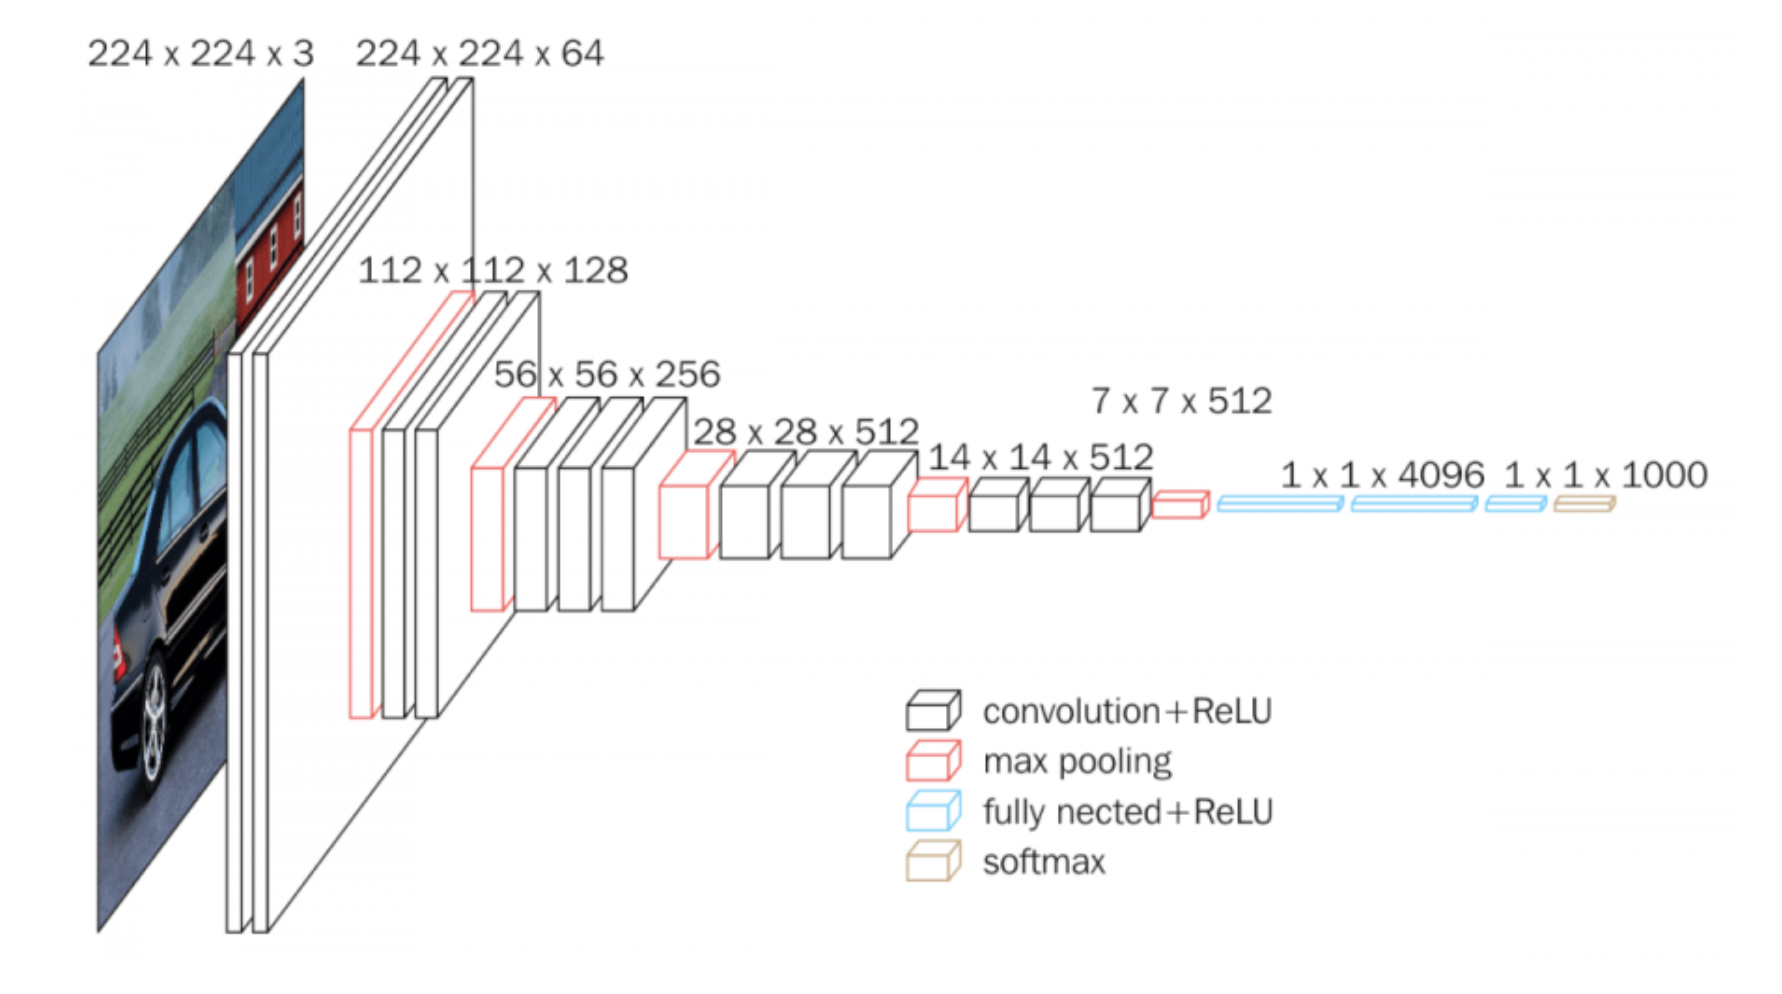

The 16 layers are:

1. Convolution using 64 filters
2. Convolution using 64 filters + Max pooling
3. Convolution using 128 filters
4. Convolution using 128 filters + Max pooling
5. Convolution using 256 filters
6. Convolution using 256 filters
7. Convolution using 256 filters + Max pooling
8. Convolution using 512 filters
9. Convolution using 512 filters
10. Convolution using 512 filters + Max pooling
11. Convolution using 512 filters
12. Convolution using 512 filters
13. Convolution using 512 filters + Max pooling
14. Fully connected with 4096 nodes
15. Fully connected with 4096 nodes
16. Output layer with Softmax activation with 4096(above figure) or 1000 (below figure) nodes


# Transfer Learning Approaches

The quickest approach to using a pre-trained CNN is to just deploy a network that was trained on a similar problem directly to your task. The pretrained model is utilized directly to classify new images, with no modifications or additional training. All you have to do is download the network architecture and its pretrained weights, then execute the predictions on the new data. This is only applicable if the the domain of the new problem is extremely similar to the one on which the pretrained network was trained. But what if this is not the case? Transfer learning is still possible using the following approaches.

## Using a Pretrained Network as a *Feature Extractor*

**Feature extraction** is the process of extracting features from a new dataset using a pre-trained model that was trained on a large dataset. The notion is that the pre-trained model has learnt to recognize general features that are relevant to many different tasks, and these features can be transferred to a new dataset that is not the same as the one on which the pre-trained model was trained. In feature extraction, we take a pretrained CNN, freeze its feature extraction part, remove the classifier part, and add our own new, dense classifier layers as shown in the image below:

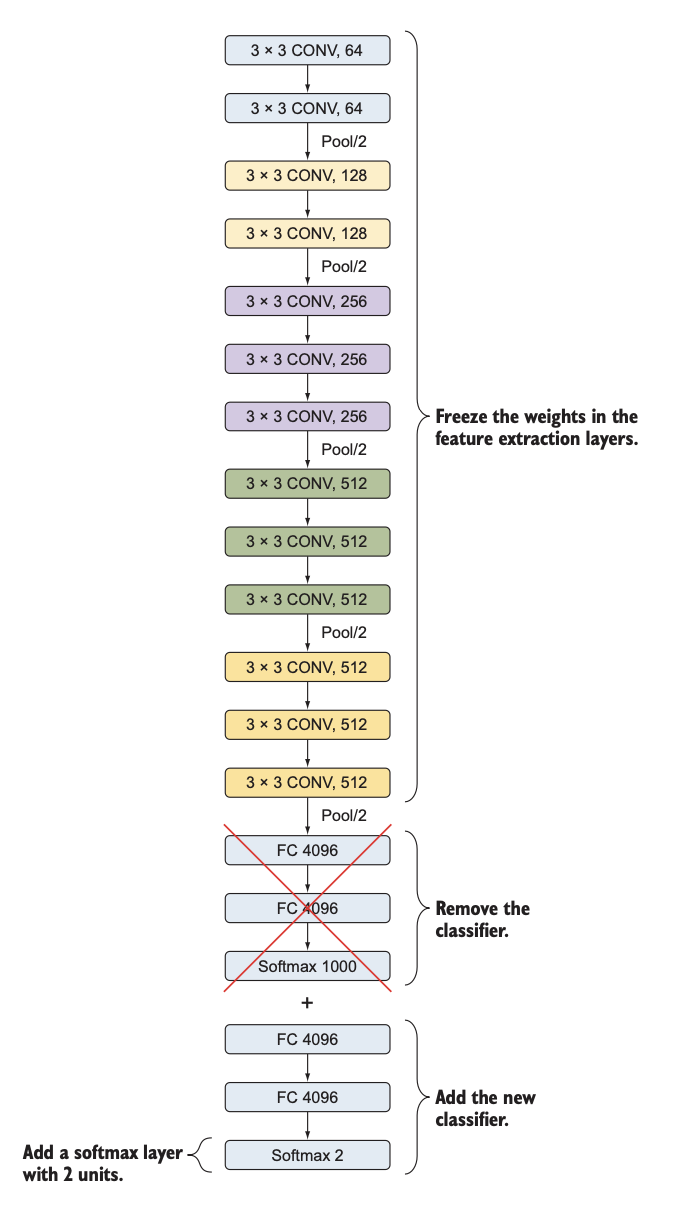

<div class="alert alert-block alert-info"> <b>QUESTIONS:</b> Why do we only reuse the convolutional base and not the dense layers? Can we also reuse the dense classifer?</div>

Let us now try to implement this approach. For this demonstration, we will use the breast ultrasound images dataset. The dataset contains breast ultrasound images of women between the ages of 25 and 75. The images are categorized into three classes: normal, benign, and malignant.    

### Data Preparation

In [1]:
# import zipfile
# with zipfile.ZipFile("data/breast_cancer.zip", 'r') as zip_ref:
#     zip_ref.extractall("data/")

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os, shutil
import torchvision
import time
import copy

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from torchsummary import summary

from PIL import Image
from pathlib import Path

In [2]:
# this function can be used to copy images to train, validation, and test dirs
def create_dataset(src, dst, range_, class_):
    """Copy images of class class_ within range_ from src to dst.
    
    Parameters
    ----------
    src : str
        source directory
    dst : str
        destination directory
    range_ : tuple
        tuple of min and max image index to copy
    class_ : str
        image class 
    """
    if os.path.exists(dst):
        # if existing, delete dir to reset
        shutil.rmtree(dst)
    os.makedirs(dst)
    fnames = [f'{class_} ({i}).png' for i in range(*range_)]
    for fname in fnames:
        src_file = os.path.join(src, fname)
        dst_file = os.path.join(dst, fname)
        shutil.copyfile(src_file, dst_file)

In [3]:
# looping through create_dataset for each class
classes = ['benign', 'malignant', 'normal']
for class_ in classes:
    src = 'data/breast_cancer' # source file
    
    dst = f'data/breast_cancer/train/{class_}' # train
    create_dataset(src+'/'+class_, dst, range_=(1, 81), class_=class_)

    dst = f'data/breast_cancer/validation/{class_}' # val
    create_dataset(src+'/'+class_, dst, range_=(81, 108), class_=class_)
    
    dst = f'data/breast_cancer/test/{class_}' # test
    create_dataset(src+'/'+class_, dst, range_=(108, 134), class_=class_)

In [4]:
train_benign_dir =  'data/breast_cancer/train/benign'
train_malignant_dir =  'data/breast_cancer/train/malignant'
train_normal_dir =  'data/breast_cancer/train/normal'

validation_benign_dir = 'data/breast_cancer/validation/benign'
validation_malignant_dir = 'data/breast_cancer/validation/malignant'
validation_normal_dir = 'data/breast_cancer/validation/normal'

test_benign_dir = 'data/breast_cancer/test/benign'
test_malignant_dir = 'data/breast_cancer/test/malignant'
test_normal_dir = 'data/breast_cancer/test/normal'

In [5]:
print('total training benign images:', len(os.listdir(train_benign_dir)))
print('total training malignant images:', len(os.listdir(train_malignant_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))

print('total validation benign images:', len(os.listdir(validation_benign_dir)))
print('total validation malignant images:', len(os.listdir(validation_malignant_dir)))
print('total validation normal images:', len(os.listdir(validation_normal_dir)))

print('total test benign images:', len(os.listdir(test_benign_dir)))
print('total test malignant images:', len(os.listdir(test_malignant_dir)))
print('total test normal images:', len(os.listdir(test_normal_dir)))

total training benign images: 80
total training malignant images: 80
total training normal images: 80
total validation benign images: 27
total validation malignant images: 27
total validation normal images: 27
total test benign images: 26
total test malignant images: 26
total test normal images: 26


We have a small dataset, with 80 images each for training and 27 images each for validation. Let's look at some sample images.

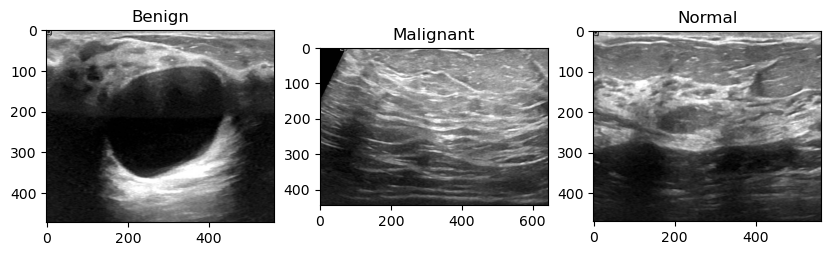

In [6]:
benign = Image.open('data/breast_cancer/train/benign/benign (80).png')
malignant = Image.open('data/breast_cancer/train/malignant/malignant (80).png')
normal = Image.open('data/breast_cancer/train/normal/normal (80).png')

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.imshow(benign);
ax1.set_title('Benign');
ax2.imshow(malignant);
ax2.set_title('Malignant');
ax3.imshow(normal);
ax3.set_title('Normal');

In [7]:
img = np.asarray(malignant)

print("image shape: ", img.shape)

image shape:  (443, 643, 3)


### Load Data

In [8]:
train_dir = "data/breast_cancer/train"
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms)

# compute for the means and stds (for normalization)
imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

print(f'Means:           {means}') 
print(f'Std. Deviations: {stds}')

Means:           [0.31836557 0.3183642  0.31834504]
Std. Deviations: [0.22442164 0.22442172 0.22441226]


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.6),             
        transforms.RandomPerspective(p=0.5),
        transforms.ColorJitter(brightness=0.5),              
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ])
}

data_dir = 'data/breast_cancer'

# loading image data using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}

# dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                             shuffle=True)
              for x in ['train', 'validation', 'test']}
# size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# class names
class_names = image_datasets['train'].classes


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Feature Extraction

We will freeze all layers except the final one. We need to freeze the parameters so that the gradients are not computed in `backward()`. This is done by setting `requires_grad` to `False`.

In [12]:
# instantiate the convolutional base
model_conv = torchvision.models.vgg16(weights='IMAGENET1K_V1') 
for param in model_conv.parameters():
    param.requires_grad = False                        

In [13]:
print(model_conv)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Let's look at the summary of the CNN.

In [14]:
summary(model_conv, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [15]:
model_conv.classifier = nn.Sequential(nn.Linear(512*7*7, 512),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(512, 3))

model_conv = model_conv.to(device)

# set the loss function
criterion = nn.CrossEntropyLoss()

# only the parameters of the classifier are being optimized
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=0.001)

In [16]:
summary(model_conv, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [17]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
model_conv = train_model(model_conv, 
                       criterion, 
                       optimizer_conv, 
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.5415 Acc: 0.5583
validation Loss: 0.8704 Acc: 0.7160

Epoch 1/49
----------
train Loss: 0.8202 Acc: 0.7292
validation Loss: 0.9376 Acc: 0.6790

Epoch 2/49
----------
train Loss: 0.5982 Acc: 0.7500
validation Loss: 1.1381 Acc: 0.6543

Epoch 3/49
----------
train Loss: 0.6129 Acc: 0.8083
validation Loss: 0.6444 Acc: 0.8148

Epoch 4/49
----------
train Loss: 0.5276 Acc: 0.8083
validation Loss: 0.7271 Acc: 0.7778

Epoch 5/49
----------
train Loss: 0.5203 Acc: 0.7875
validation Loss: 0.9040 Acc: 0.7531

Epoch 6/49
----------
train Loss: 0.4456 Acc: 0.8083
validation Loss: 0.7325 Acc: 0.8025

Epoch 7/49
----------
train Loss: 0.3885 Acc: 0.8458
validation Loss: 0.7844 Acc: 0.8025

Epoch 8/49
----------
train Loss: 0.3782 Acc: 0.8625
validation Loss: 0.8383 Acc: 0.7778

Epoch 9/49
----------
train Loss: 0.3111 Acc: 0.8750
validation Loss: 0.8934 Acc: 0.7407

Epoch 10/49
----------
train Loss: 0.3328 Acc: 0.8750
validation Loss: 0.9111 Acc: 0.7407

Epoch 11/

In [19]:
def evaluate(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    print("Test Accuracy: {:.4f}".format(correct / total))

In [20]:
evaluate(model_conv, dataloaders['test'])

Test Accuracy: 0.8974


### Visualize Model Predictions

In [35]:
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {class_names[preds[j]]}')
            plt.imshow(inputs.cpu().data[j].transpose(1,2,0))

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_preds(model):
    # get batch of images from the test DataLoader  
    images, labels = next(iter(dataloaders['test']))
    images = images.to(device)
    labels = labels.to(device)

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images.cpu()))
   
    # show the real labels  
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(4)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # show the predicted labels 
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


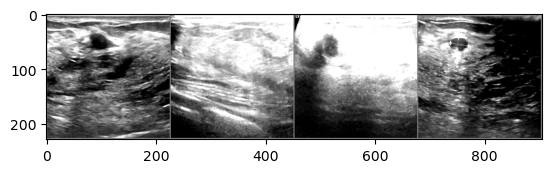

Real labels:  benign benign malignant benign
Predicted:  benign normal malignant malignant


In [61]:
visualize_preds(model_conv)

## Fine-tuning

Feature extraction works well when the target domain is somewhat similar to the source domain. But, can we still use transfer learning if the target domain and source domain are different? Yes, even when the domains are highly dissimilar, transfer learning is very effective. Just the right feature maps need to be extracted from the source domain and adjusted to fit the target domain.

Fine-tuning is defined as *"the freezing a few of the network layers that are used for feature extraction, and jointly training both the non-frozen layers and the newly added classifier layers of the pretrained model."* When we retrain the feature extraction layers, we fine-tune the representations of the higher-order features to make them more relevant to the new task dataset.

<div class="alert alert-block alert-info"> <b>QUESTION:</b> Is fine-tuning better than training the model from scratch? Explain your answer.</div>

Let's try to fine-tune VGG-16 on our breast ultrasound dataset. 

In [22]:
vgg16_ft = torchvision.models.vgg16(weights='IMAGENET1K_V1') 

Again, this is the architecture of VGG-16. 

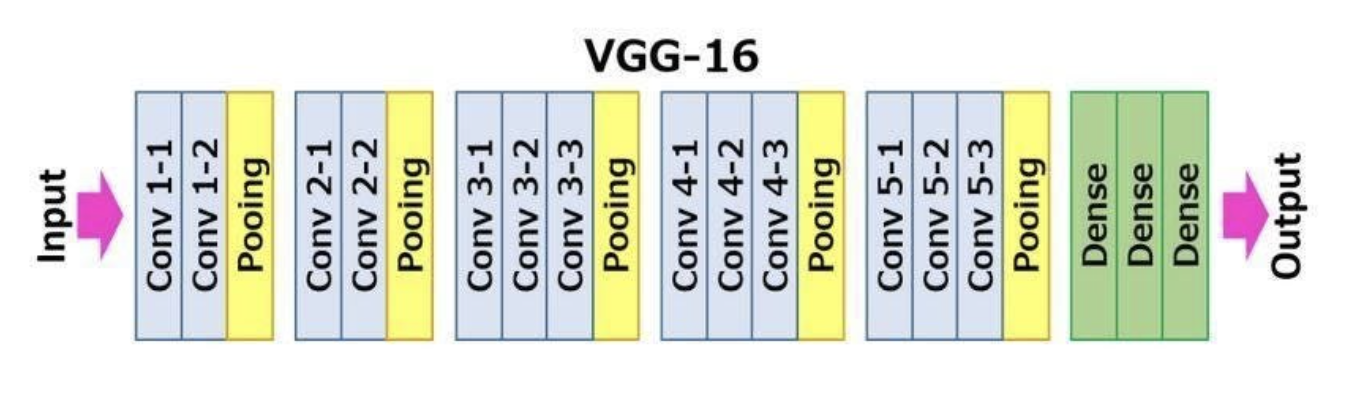

Suppose, we want to fine-tune the convolutional block 5. This would mean freezing all the other layers except for this block. 

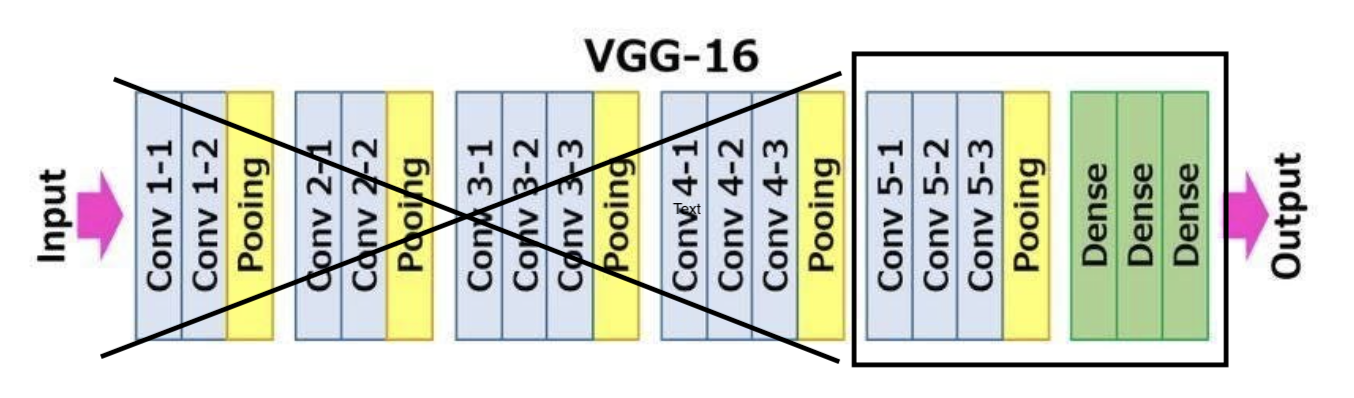

But how do we do that? First, let us look at the model's layers. We can access this by simply printing the model.

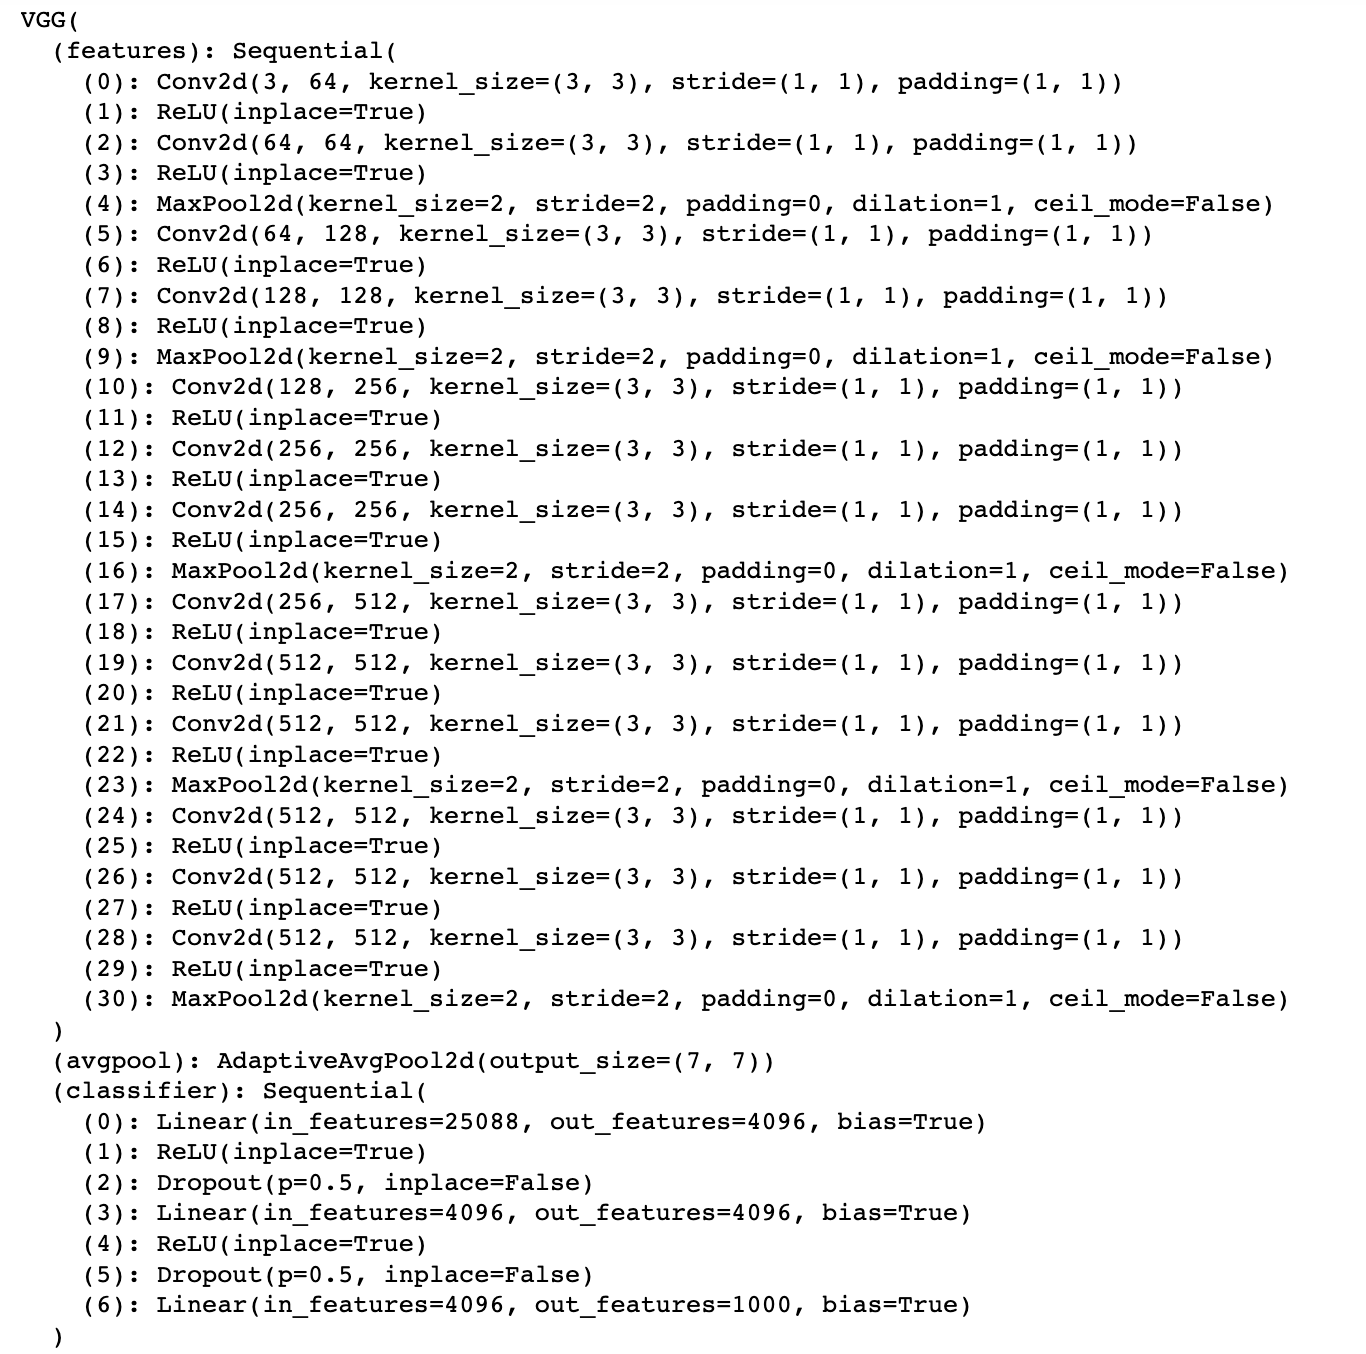

Based on the image above, convolutional block 5 includes the following feature layers: `features[24]`, `features[26]`, and `features[28]`.

In [23]:
vgg16_ft.classifier = nn.Sequential(nn.Linear(512*7*7, 512),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(512, 3))
# setting parameters to fine-tune
params_to_update = ['features.24.weight', 'features.24.bias',
                    'features.26.weight', 'features.26.bias',
                    'features.28.weight', 'features.28.bias',
                    'classifier.0.weight', 'classifier.0.bias',
                    'classifier.3.weight', 'classifier.3.bias',
                    'classifier.6.weight', 'classifier.6.bias']

# store parameters in list
params = []
for name, param in vgg16_ft.named_parameters():
    for parameters in params_to_update:        
        if parameters in name:
            param.requires_grad = True
            params.append(param)

In [24]:
len(params)

10

In [26]:
vgg16_ft = vgg16_ft.to(device)

# set the loss function
criterion = nn.CrossEntropyLoss()

# the parameters of the last concolutional block and classifier are being optimized
optimizer_vgg16_ft = optim.Adam(params, lr=0.001)

In [27]:
vgg16_ft = train_model(vgg16_ft, 
                       criterion, 
                       optimizer_vgg16_ft, 
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.1569 Acc: 0.4042
validation Loss: 1.0018 Acc: 0.5062

Epoch 1/49
----------
train Loss: 0.9980 Acc: 0.6292
validation Loss: 1.0674 Acc: 0.4198

Epoch 2/49
----------
train Loss: 0.9462 Acc: 0.5500
validation Loss: 0.8326 Acc: 0.5679

Epoch 3/49
----------
train Loss: 1.0480 Acc: 0.6542
validation Loss: 0.7801 Acc: 0.5926

Epoch 4/49
----------
train Loss: 0.8242 Acc: 0.5708
validation Loss: 0.7303 Acc: 0.6049

Epoch 5/49
----------
train Loss: 0.7598 Acc: 0.6375
validation Loss: 1.6202 Acc: 0.5802

Epoch 6/49
----------
train Loss: 1.0507 Acc: 0.5125
validation Loss: 0.8207 Acc: 0.5679

Epoch 7/49
----------
train Loss: 0.9763 Acc: 0.5500
validation Loss: 1.0610 Acc: 0.3951

Epoch 8/49
----------
train Loss: 0.9337 Acc: 0.4875
validation Loss: 0.8750 Acc: 0.5432

Epoch 9/49
----------
train Loss: 1.0321 Acc: 0.5042
validation Loss: 0.8268 Acc: 0.5679

Epoch 10/49
----------
train Loss: 0.8224 Acc: 0.6542
validation Loss: 0.7929 Acc: 0.5926

Epoch 11/

In [28]:
evaluate(vgg16_ft, dataloaders['test'])

Test Accuracy: 0.5769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


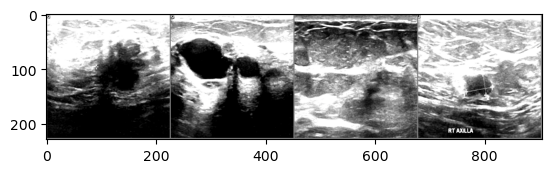

Real labels:  malignant benign normal malignant
Predicted:  normal benign normal normal


In [66]:
visualize_preds(vgg16_ft)

Based on the results of our runs, feature extraction resulted in a higher level of test accuracy. How can this be? How do we determine which transfer learning strategy to implement? 

# Choosing the appropriate level of transfer learning

We now know the different approaches of transfer learning. But, how will we choose the level of detail for feature extraction from an existing pretrained model? How many convolutional blocks should we fine-tune?

The appropriate level for transfer learning is determined by two crucial factors:

* ***Size of the target dataset*** - When we have a limited dataset, the network is unlikely to learn much from training additional layers, so it will likely overfit the new data. In this situation, we should presumably perform less fine-tuning and rely more on the original dataset.

* ***Domain similarity of the source and target datasets*** - If your problem is to classify animals, ImageNet could be an option because it contains a large number of images with similar characteristics. Alternatively, if your problem is to classify lung cancer on X-ray images, this is an entirely distinct domain that will likely require a lot of fine-tuning.

The diagram below summarizes the appropriate level of transfer learning given these factors (Elgendy, 2020).

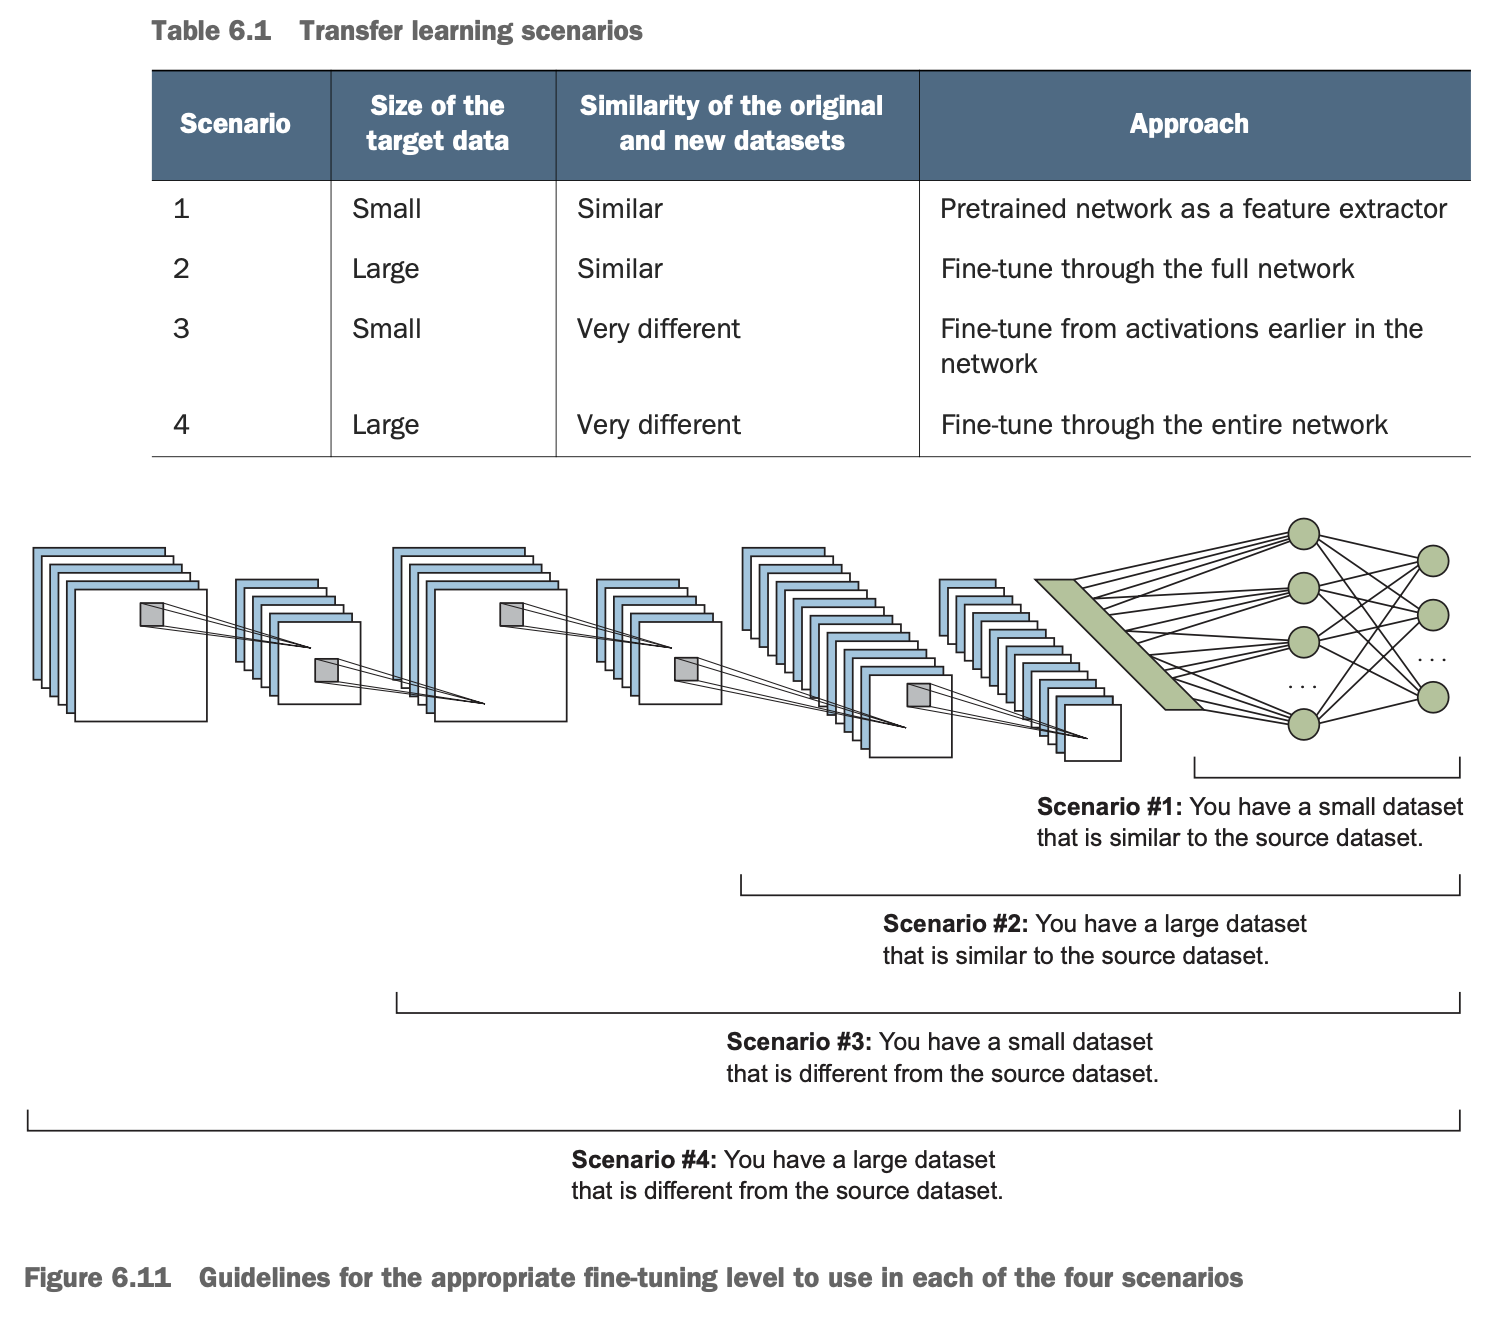

# Summary
Here are some key takeaways from our exercise today:
   
* It is simple to utilize **feature extraction** to reuse an existing CNN on a new set of data. This is a useful method for working with small image datasets.   

* In addition to feature extraction, you can employ **fine-tuning**, which applies some of the representations previously learned by an existing model to a new problem. This further improves model performance.

* When choosing the appropriate level of transfer learning, factors to consider are the **dataset size and domain similarity of the source and target datasets**.

# References:

## Main References:
* Elgendy, M. (2020, November 10). Deep Learning for Vision Systems. Manning Publications Co.
* *Transfer Learning for Computer Vision Tutorial — PyTorch Tutorials 2.0.0+cu117 documentation*. (n.d.). Transfer Learning for Computer Vision Tutorial — PyTorch Tutorials 2.0.0+cu117 Documentation. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

* **Dataset**: Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. *Data Brief* 28, 104863 (2020).


## Original Papers:

* Alzubaidi, L., Santamaría, J., Manoufali, M., Mohammed, B., Fadhel, M. A., Zhang, J., Al-Timemy, A.H., Al-Shamma, O. & Duan, Y. (2021). MedNet: pre-trained convolutional neural network model for the medical imaging tasks. *arXiv preprint* arXiv:2110.06512.
* He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 770-778).
* Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 4700-4708).
* Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2017). Imagenet classification with deep convolutional neural networks. *Communications of the ACM*, 60(6), 84-90.
* Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). Mobilenetv2: Inverted residuals and linear bottlenecks. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 4510-4520).
* Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. *arXiv preprint* arXiv:1409.1556.
* Tan, M., & Le, Q. (2019, May). Efficientnet: Rethinking model scaling for convolutional neural networks. In *International conference on machine learning* (pp. 6105-6114). PMLR.